Fine tuning a BERT model from Hugging Face using the HF Trainer api on custom dataset to classify whether a comment is toxic or not toxic.

In [1]:
%%capture
!pip install transformers

In [2]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv("/content/drive/MyDrive/toxic_comments_train.csv")
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
len(data)

159571

In [6]:
def clean_text(text):
    '''Remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    
    #pattern = [zero or more character]
    text = re.sub('\[.*?\]', '', text)
    
    #pattern = with or without(http),://, one or more non-white space character, OR www, .,one or more non-white space character
    text = re.sub('https?://\S+|www\.\S+', '', text)
    
    #pattern = <, zero or more characters, >, (one or more occurance of >)
    text = re.sub('<.*?>+', '', text)
    
    #pattern = any punctionation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    
    #pattern = any new line
    text = re.sub('\n', ' ', text)
    
    #pattern = any from[a-zA-Z0-9_], any from[0-9], any from [a-zA-Z0-9_]
    text = re.sub('\w*\d\w*', '', text)

    #remove extra spaces
    text = " ".join(text.split())

    return text

data['comment_text'] = data['comment_text'].apply(clean_text)

In [7]:
# Let's check out first five comments

for text in data['comment_text'][0:5]:
  print(text, '\n')

Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They werent vandalisms just closure on some GAs after I voted at New York Dolls FAC And please dont remove the template from the talk page since Im retired 

Daww He matches this background colour Im seemingly stuck with Thanks talk January UTC 

Hey man Im really not trying to edit war Its just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page He seems to care more about the formatting than the actual info 

More I cant make any real suggestions on improvement I wondered if the section statistics should be later on or a subsection of types of accidents I think the references may need tidying so that they are all in the exact same format ie date format etc I can do that later on if noone else does first if you have any preferences for formatting style on references or want to do it yourself please let me know There appears to be a backlog

<Axes: >

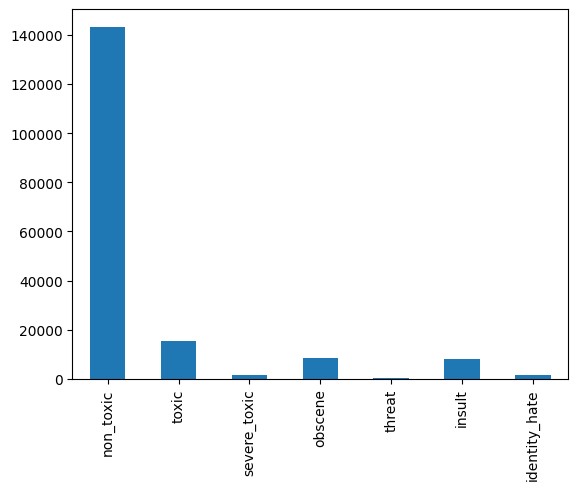

In [8]:
data['non_toxic'] = data['toxic']+data['severe_toxic']+data['obscene']+data['threat']+data['insult']+data['identity_hate']

# We will change the value to 1 (meaning non toxic) if the value is 0 and set it to 0 for all other cases
data['non_toxic'] = data['non_toxic'].apply(lambda x: 1 if x==0 else 0)

data[['non_toxic','toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum().plot.bar()

We can clearly see that the dataset is highly imbalanced. Let's make the training dataset balanced. We will club all categories that are other than Non-Toxic into the Toxic umbrella category.

In [9]:
data['toxic'] = np.where(data['non_toxic']==1, 0, 1)

# We only need comments and label columns 
data = data[['comment_text', 'toxic']]   

data_toxic = data[data['toxic']==1]
data_nontoxic = data[data['toxic']==0]
data = pd.concat([data_toxic, data_nontoxic.head(len(data_toxic))], axis=0)
data['toxic'].value_counts()

1    16225
0    16225
Name: toxic, dtype: int64

In [10]:
# Splitting the data into train, validation and test sets

X = list(data['comment_text'])
y = list(data['toxic'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, stratify=y, random_state=40)

# Now we will keep a separate portion for the test set from the validation set

X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val, random_state=40)

In [11]:
from transformers import BertTokenizer, BertForSequenceClassification

checkpoint = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(checkpoint)
model = BertForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [12]:
# Making the code device agnostic

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [13]:
# Let's tokenize the datasets

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

In [14]:
X_train_tokenized.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [15]:
# Let's define the torch Dataset class

class Dataset(torch.utils.data.Dataset):

    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [16]:
# Let's create the train, val and test Datasets

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)
test_dataset = Dataset(X_test_tokenized, y_test)

In [31]:
# Let's check a sample from the train dataset

train_dataset[0]

{'input_ids': tensor([  101,  2023,  3720, 19237,  2023,  3720,  2003,  2074,  2019,  3424,
          2175,  2243, 25368,  3720,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [18]:
# Let's define the compute metrics function

def compute_metrics(prediction):
    
    logits, labels = prediction
    pred = np.argmax(logits, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 score": f1}

In [19]:
# Let's create the Trainer object

args = TrainingArguments(output_dir="bert_output",
                         num_train_epochs=2,
                         per_device_train_batch_size=16
)

trainer = Trainer(model=model,
                  args=args,
                  train_dataset=train_dataset,
                  eval_dataset=val_dataset,
                  compute_metrics=compute_metrics
)     

In [20]:
# Training the BERT model now

trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.258500
1000,0.213600
1500,0.194000
2000,0.115800
2500,0.107000
3000,0.104800


TrainOutput(global_step=3044, training_loss=0.16453423324615038, metrics={'train_runtime': 4507.3592, 'train_samples_per_second': 10.799, 'train_steps_per_second': 0.675, 'total_flos': 1.280666750859264e+16, 'train_loss': 0.16453423324615038, 'epoch': 2.0})

In [21]:
# Evaluating the model

trainer.evaluate()

{'eval_loss': 0.231308713555336,
 'eval_Accuracy': 0.9381316243529702,
 'eval_Precision': 0.9327812956648807,
 'eval_Recall': 0.9442800788954635,
 'eval_F1 score': 0.9384954667973536,
 'eval_runtime': 136.9523,
 'eval_samples_per_second': 29.623,
 'eval_steps_per_second': 3.709,
 'epoch': 2.0}

In [28]:
sample = ["You are stupid enough to go there alone.", 
          "I am going home", 
          "fuck you!!", 
          "I love you more everyday.", 
          "I loved you but not anymore since I am now over you, so kindly leave me alone.",
          "This course is shit! I'd rather learn on my own..."]

inputs = tokenizer(sample, padding=True, truncation=True, return_tensors="pt").to(device)

output = model(**inputs)

# Printing the model output logits
print(output.logits)

tensor([[-3.7035,  3.6156],
        [ 2.3244, -2.5289],
        [-4.0192,  3.8229],
        [ 3.2362, -3.1500],
        [ 1.7837, -2.1087],
        [-3.4537,  3.3232]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [29]:
# Let's convert the model output logits into probabilites by passing them through the Softmax function

predictions = torch.softmax(output.logits, dim=-1)
print(predictions)
preds_array = predictions.detach().cpu().numpy()

# Displaying the model predictions

for i, pred in enumerate(preds_array):
  if pred[0] > pred[1]:
    print("\nComment:", sample[i],"\nPrediction: Not Toxic", "\nProbability:", pred[0])
  else:
    print("\nComment:", sample[i],"\nPrediction: Toxic", "\nProbability:", pred[1])

tensor([[6.6233e-04, 9.9934e-01],
        [9.9226e-01, 7.7415e-03],
        [3.9268e-04, 9.9961e-01],
        [9.9832e-01, 1.6818e-03],
        [9.8001e-01, 1.9989e-02],
        [1.1386e-03, 9.9886e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

Comment: You are stupid enough to go there alone. 
Prediction: Toxic 
Probability: 0.9993376

Comment: I am going home 
Prediction: Not Toxic 
Probability: 0.9922585

Comment: fuck you!! 
Prediction: Toxic 
Probability: 0.9996074

Comment: I love you more everyday. 
Prediction: Not Toxic 
Probability: 0.9983182

Comment: I loved you but not anymore since I am now over you, so kindly leave me alone. 
Prediction: Not Toxic 
Probability: 0.980011

Comment: This course is shit! I'd rather learn on my own... 
Prediction: Toxic 
Probability: 0.99886143


In [30]:
# Saving the model

trainer.save_model("/content/drive/MyDrive/custom_BERT_model")